# <center>  **Customer Segmentation Strategy: Optimizing 6-Month Marketing ROI through RFM Clustering**

### **Table of Contents**

1. [Introduction](#Introduction)
2. [Data Loading & Cleaning](#import-data)
3. [Feature Engineering](#feature-engineering)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
5. [RFM Analysis & Customer Segmentation](#customer-segmentation-with-k-means)
5. [Conclusion](#conclusion)

--- 
### **Introduction**

- **Purpose**: Develop a data-driven customer segmentation framework using **K-Means clustering** to **optimize marketing budget** allocation and retention strategies. By analyzing Recency, Frequency, and Monetary (RFM) behaviors, this project identifies distinct customer personal and provides a prescriptive financial roadmap for reinvestment based on actual 6-month value. **The goal is to maximize ROI by shifting from "mass marketing" to "segment-specific" spending strategies.**

- **Dataset Overview**:

   - This project uses one primary dataset: customer_lifetime_value_dataset.csv (~10,000 records)
   - Contains key customer features including: The dataset tracks customer behavior and value, using purchase dates to measure recency and tenure alongside sales metrics like total revenue and average order value. It also captures engagement through referral sources, product categories, campaign responses, and feedback scores. Additional operational data, such as payment methods, discounts, support tickets, loyalty status, and churn indicators, provides a complete view of the customer relationship.
---

# Import Data

#### Data Loading

In [642]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#regular expression
import re

import warnings
warnings.filterwarnings("ignore")

In [643]:
# Load and examine the initial structure of the datasets required for this analysis.
clv = pd.read_csv('customer_lifetime_value_dataset.csv')
clv.head()

,customerid,firstpurchasedate,lastpurchasedate,totalpurchases,totalrevenue,referralsource,churnindicator,discountsused,productcategory,responsetolastcampaign,feedbackscore,preferredpaymentmethod,supportticketsraised,hasloyaltycard,frequency
0,8519,2021-12-31,2022-03-06,7,11670,Online advertisements,0,2,Q02,ignored,4.729998,debit card,0,no,7
1,38152,2019-09-27,2023-02-02,20,5260,Traditional media outreach,1,6,F76,purchased,4.184512,cash,0,no,2
2,19680,2021-06-13,2022-02-04,29,9790,Influencer endorsements,0,2,X04,opened mail,4.346640,google pay,0,no,4
3,35744,2021-07-28,2022-08-21,15,9591,Influencer endorsements,0,5,A25,ignored,5.000000,debit card,0,no,13
4,11663,2021-01-19,2022-03-10,13,10134,Word of mouth,0,3,A16,ignored,4.482089,credit card,0,no,11


In [644]:
# convert to date to datetime value
clv['firstpurchasedate'] = pd.to_datetime(clv['firstpurchasedate'])
clv['lastpurchasedate'] = pd.to_datetime(clv['lastpurchasedate'])

#### Data Cleaning

Checking missing values and cardinality of each feature with sniff modified function

In [645]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')
    
sniffed = sniff_modified(clv)

sniffed

,data type,percent missing,No. unique,unique values
customerid,int64,0.0,10000,"[8519, 38152, 19680, 35744, 11663, 23498, 2273..."
firstpurchasedate,datetime64[ns],0.0,1526,"[2021-12-31 00:00:00, 2019-09-27 00:00:00, 202..."
lastpurchasedate,datetime64[ns],0.0,1530,"[2022-03-06 00:00:00, 2023-02-02 00:00:00, 202..."
totalpurchases,int64,0.0,40,"[7, 20, 29, 15, 13, 8, 25, 26, 19, 23, 11, 16,..."
totalrevenue,int64,0.0,5784,"[11670, 5260, 9790, 9591, 10134, 10665, 4866, ..."
churnindicator,int64,0.0,2,"[0, 1]"
discountsused,int64,0.0,7,"[2, 6, 5, 3, 4, 1, 0]"
frequency,int64,0.0,31,"[7, 2, 4, 13, 11, 29, 21, 17, 6, 8, 1, 3, 12, ..."
feedbackscore,float64,0.0,5049,"[4.72999831098997, 4.184511995598712, 4.346639..."
referralsource,object,0.0,8,"[Online advertisements, Traditional media outr..."


In [646]:
# Cleaning supportticketsraised - assump that <2 is 1
clv['supportticketsraised'] = clv['supportticketsraised'].replace('<2', '1')

# Feature Engineering:

- The original dataset does not include key features like AOV, Recency, Tenure, or Average Days Between Purchases.

- We will create these first before moving on to the analysis.

In [647]:
# 'avgpurchasevalue (AOV)' - Average value of purchases made by the customer (totalrevenue/totalpurchases).
clv['AOV'] = clv['totalrevenue'] / clv['totalpurchases']

In [648]:
from datetime import datetime
# Snapshot date setup for CLV analysis
# today = datetime(2023, 9, 1)    # Original full-period date (not used)
snapshot = datetime(2023, 3, 1)     # Snapshot date: March 1, 2023 (USED)

# Explanation:
# We use March 1, 2023 as the analysis snapshot.
# This creates a realistic 6-month prediction window (Mar-Sep 2023).

In [649]:
# 'recency' - Number of days since the last purchase.
clv['recency'] = (snapshot - clv['lastpurchasedate']).dt.days

In [650]:
# 'tenure' - Number of days since the customer's first purchase (for understanding how long they've been a customer).
clv['tenure'] = (snapshot - clv['firstpurchasedate']).dt.days

In [651]:
#'avgtimebetweenpurchases' - TBP: Average number of days between purchases.
clv['avgtimebetweenpurchases'] = (clv['lastpurchasedate'] - clv['firstpurchasedate']).dt.days/ clv['totalpurchases']

# Exploratory Data Analysis (EDA)

In [652]:
# Compute and display basic statistical summaries (mean, median, standard deviation, etc.) for all the numerical columns in the dataset.
clv.describe()

,customerid,firstpurchasedate,lastpurchasedate,totalpurchases,totalrevenue,churnindicator,discountsused,feedbackscore,frequency,AOV,recency,tenure,avgtimebetweenpurchases
count,10000.000000,10000,10000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,27519.237400,2020-08-20 10:49:00.480000,2022-02-24 23:18:23.040000,19.28050,8521.876100,0.498700,2.993600,4.433905,10.053700,629.636381,369.028900,922.549300,34.666420
min,5000.000000,2019-02-04 00:00:00,2019-02-24 00:00:00,1.00000,4401.000000,0.000000,0.000000,1.006071,1.000000,123.150000,-182.000000,-177.000000,0.000000
25%,16144.750000,2019-09-17 00:00:00,2021-05-27 00:00:00,13.00000,6427.750000,0.000000,1.000000,4.251318,4.000000,314.570238,38.000000,637.000000,13.649265
50%,27617.000000,2020-06-21 00:00:00,2022-05-05 12:00:00,20.00000,8543.000000,0.000000,3.000000,4.985672,9.000000,435.362732,299.500000,983.000000,26.888889
75%,38967.250000,2021-06-02 00:00:00,2023-01-22 00:00:00,26.00000,10589.250000,1.000000,5.000000,5.000000,14.000000,649.432456,643.000000,1261.000000,42.265873
max,49994.000000,2023-08-25 00:00:00,2023-08-30 00:00:00,40.00000,12678.000000,1.000000,6.000000,5.000000,31.000000,12658.000000,1466.000000,1486.000000,1479.000000
std,13118.347463,NaN,NaN,7.82962,2388.452322,0.500023,2.005283,0.920760,7.098652,816.565606,392.283779,392.949289,44.310563


### Univariate Analysis:

**Numerical Values**

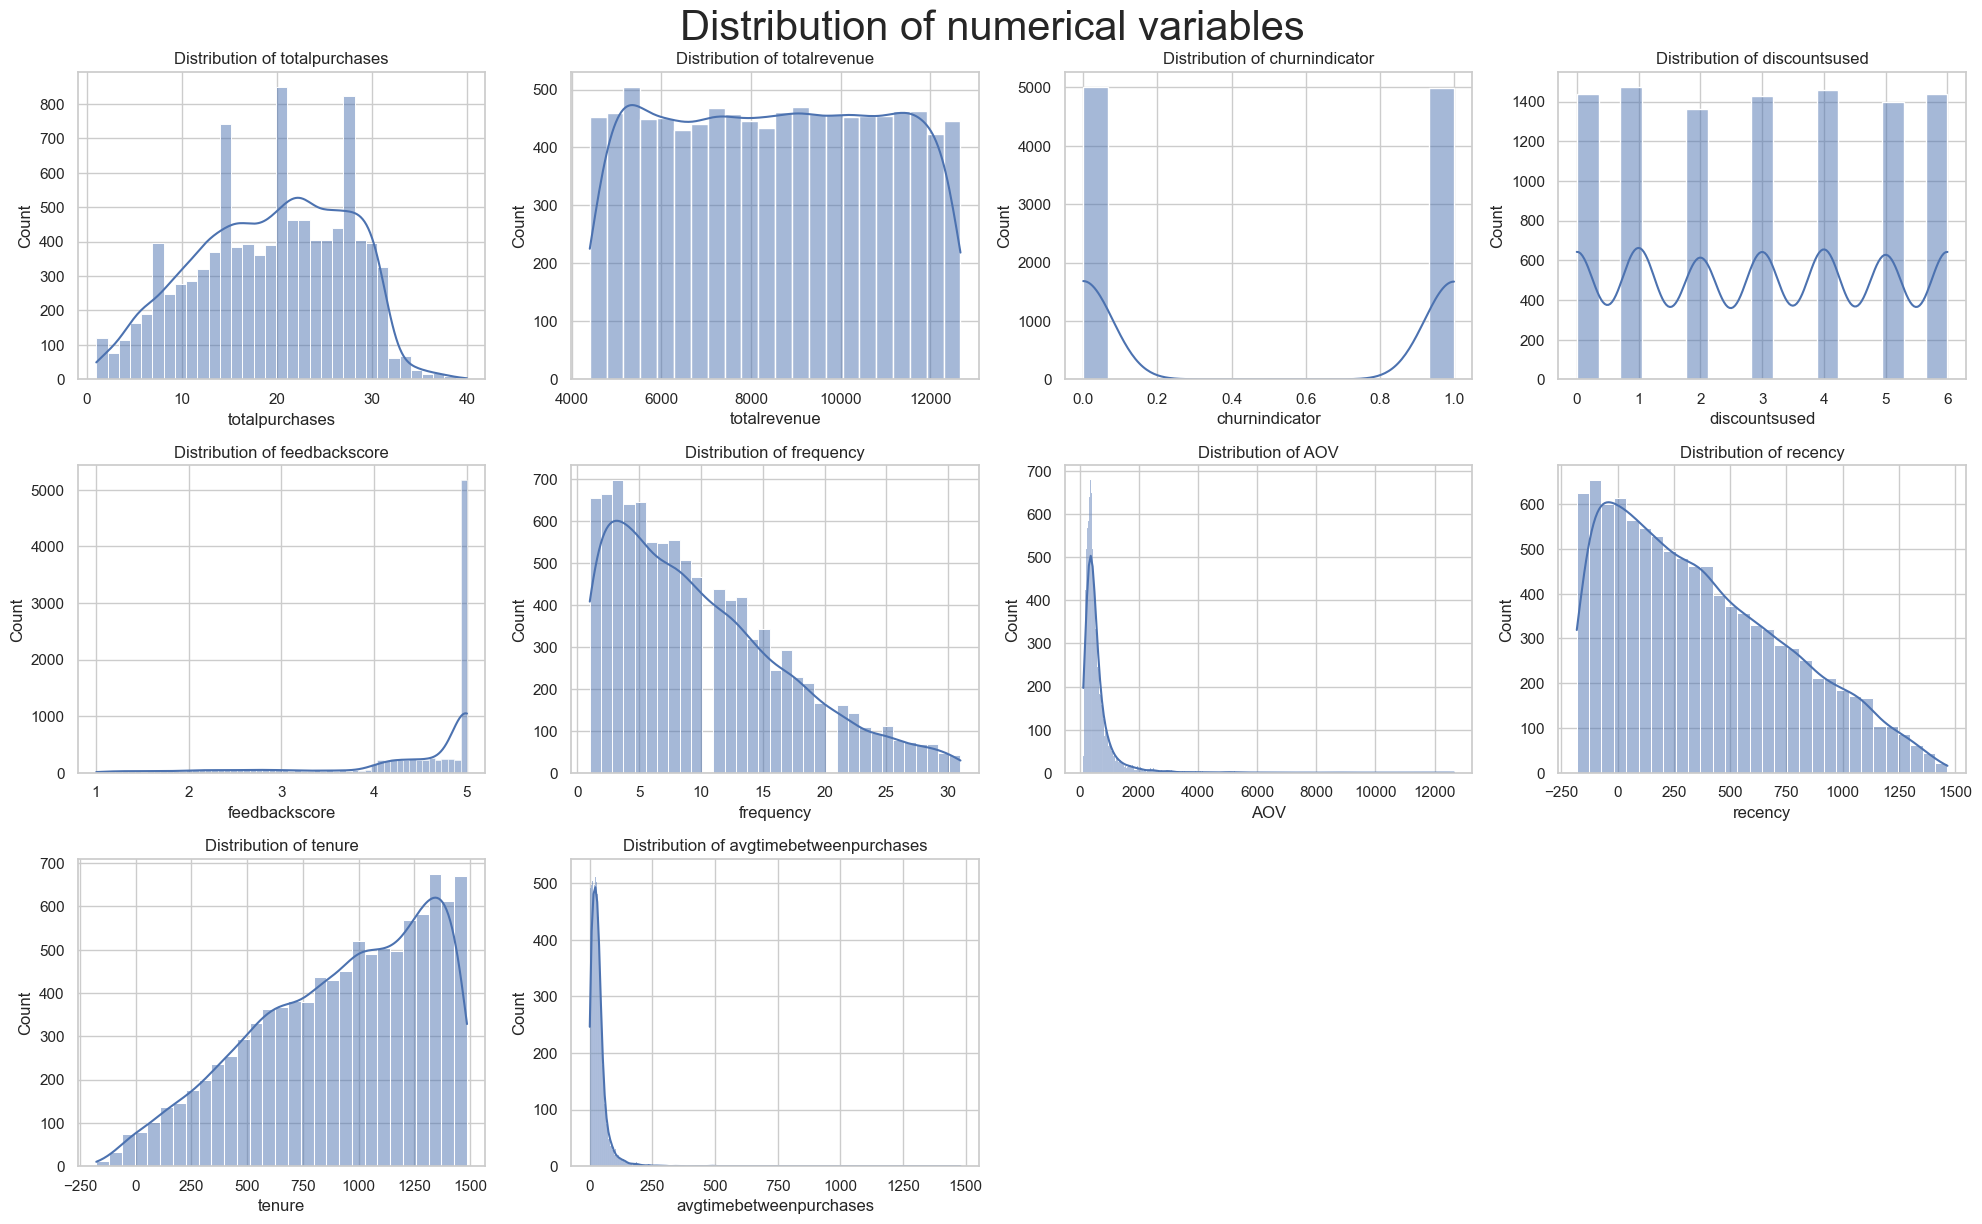

In [653]:
numerical_columns = clv.select_dtypes(include=['number']).drop('customerid',axis=1).columns

# Set up the subplot grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(numerical_columns):
    if i < len(axes):
        sns.histplot(data=clv, x=column, ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {column}', fontsize=12)

# Remove any empty subplots
for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Distribution of numerical variables", size=30)

plt.tight_layout()
plt.show()

**Categorical Values**

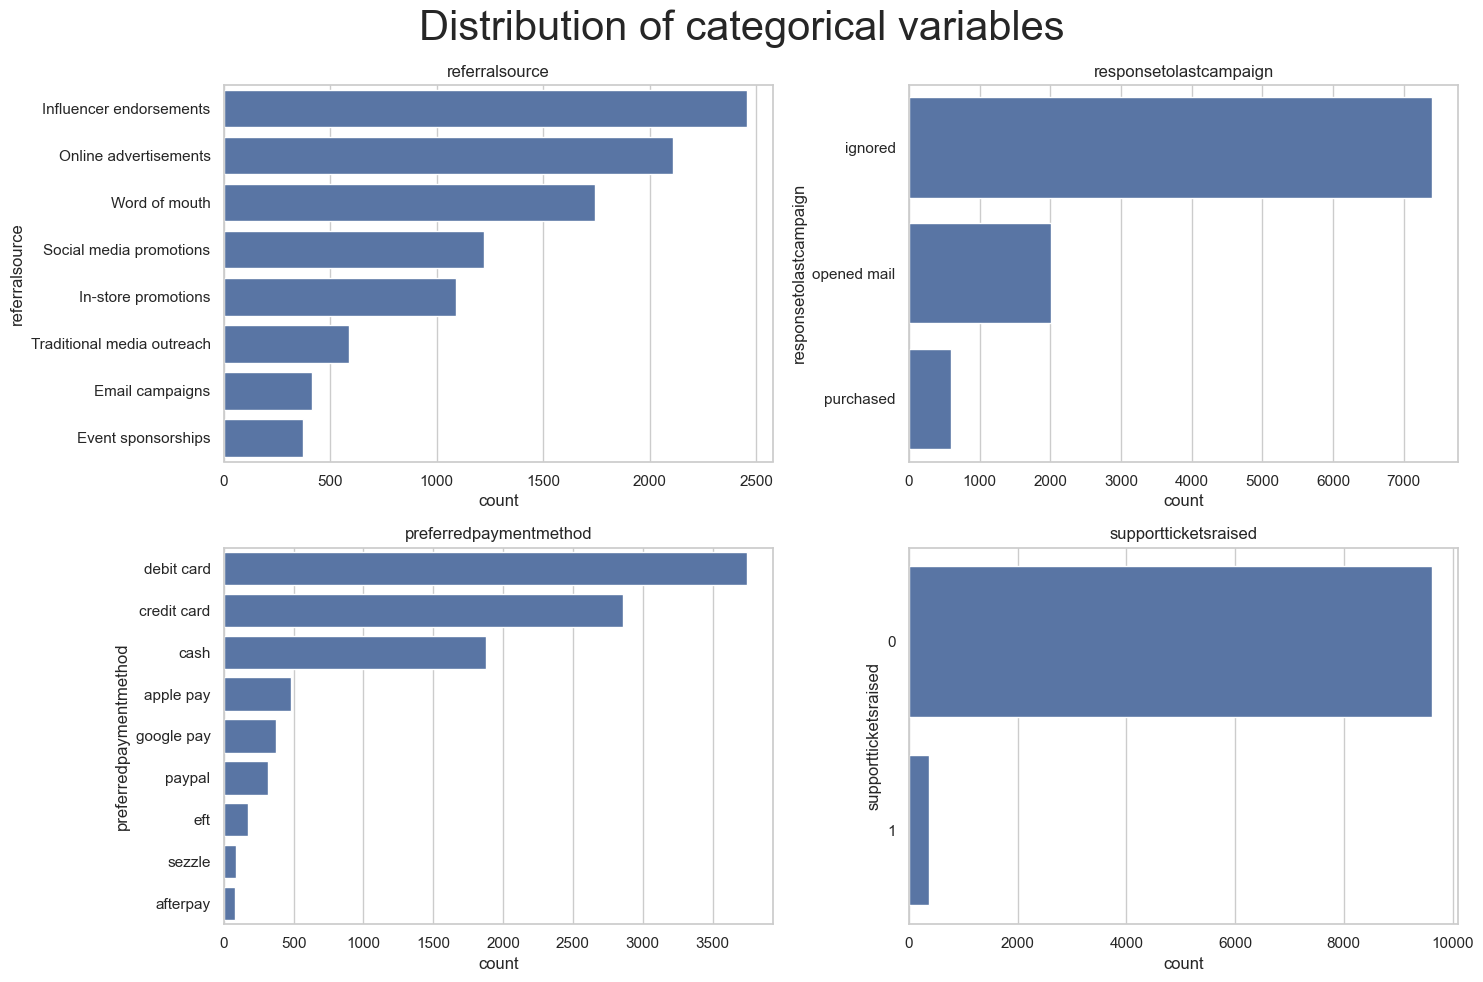

In [654]:
# Get categorical columns (excluding 'productcategory')
cat_cols = [col for col in clv.select_dtypes(include=['object']).columns if col != 'productcategory']

# Create subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot each categorical variable as horizontal bars
for idx, col in enumerate(cat_cols):
    if idx < 4:  # Limit to 4 plots
        sns.countplot(data=clv, y=col, ax=axes[idx], order=clv[col].value_counts().index)
        axes[idx].set_title(col)

fig.suptitle("Distribution of categorical variables", size=30)

plt.tight_layout()
plt.show()

# Customer Segmentation with K-Means

In [655]:
rfm = clv[['customerid', 'recency', 'frequency', 'totalrevenue' ]] # getting indicator for rfm
rfm.rename(columns={'totalrevenue':'monetary'},inplace=True)
rfm[['recency', 'frequency', 'monetary' ]].describe()

,recency,frequency,monetary
count,10000.000000,10000.000000,10000.000000
mean,369.028900,10.053700,8521.876100
std,392.283779,7.098652,2388.452322
min,-182.000000,1.000000,4401.000000
25%,38.000000,4.000000,6427.750000
50%,299.500000,9.000000,8543.000000
75%,643.000000,14.000000,10589.250000
max,1466.000000,31.000000,12678.000000


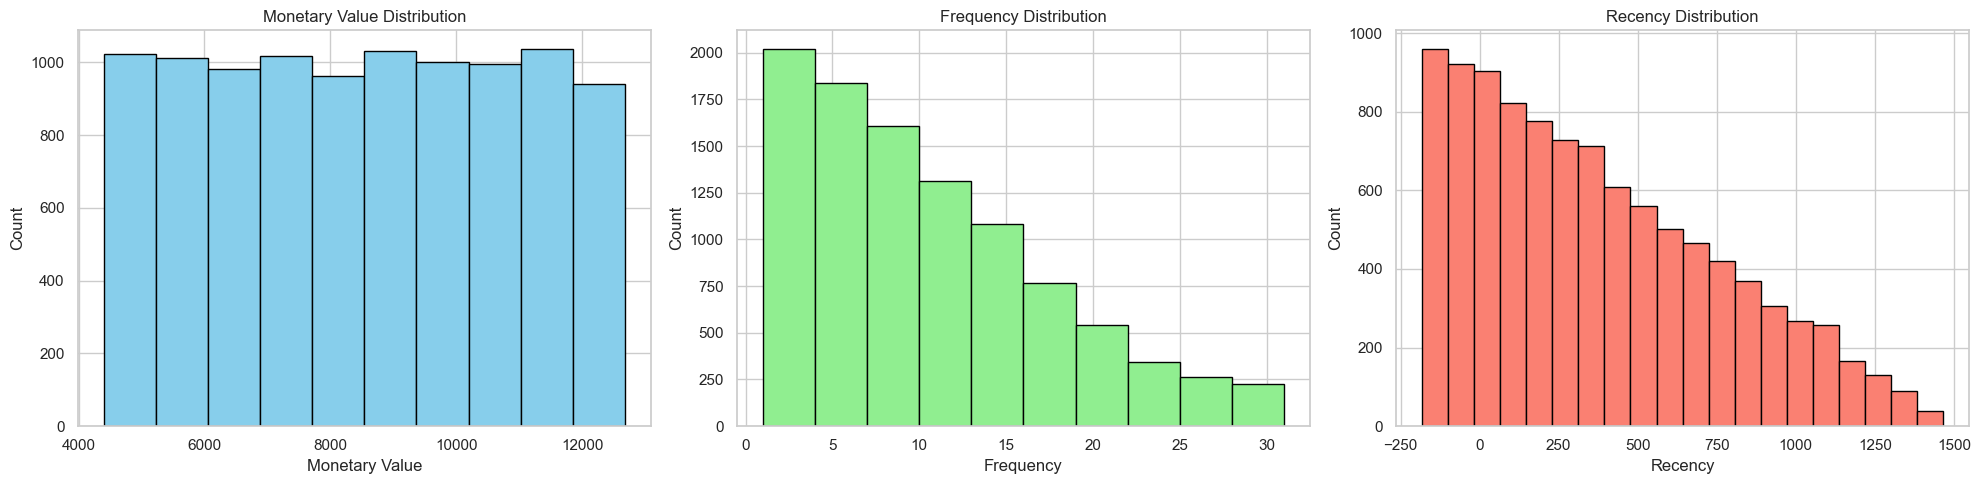

In [656]:
# We want to observe to see outliers, we can use bar graphs for it
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(rfm['monetary'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(rfm['frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(rfm['recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

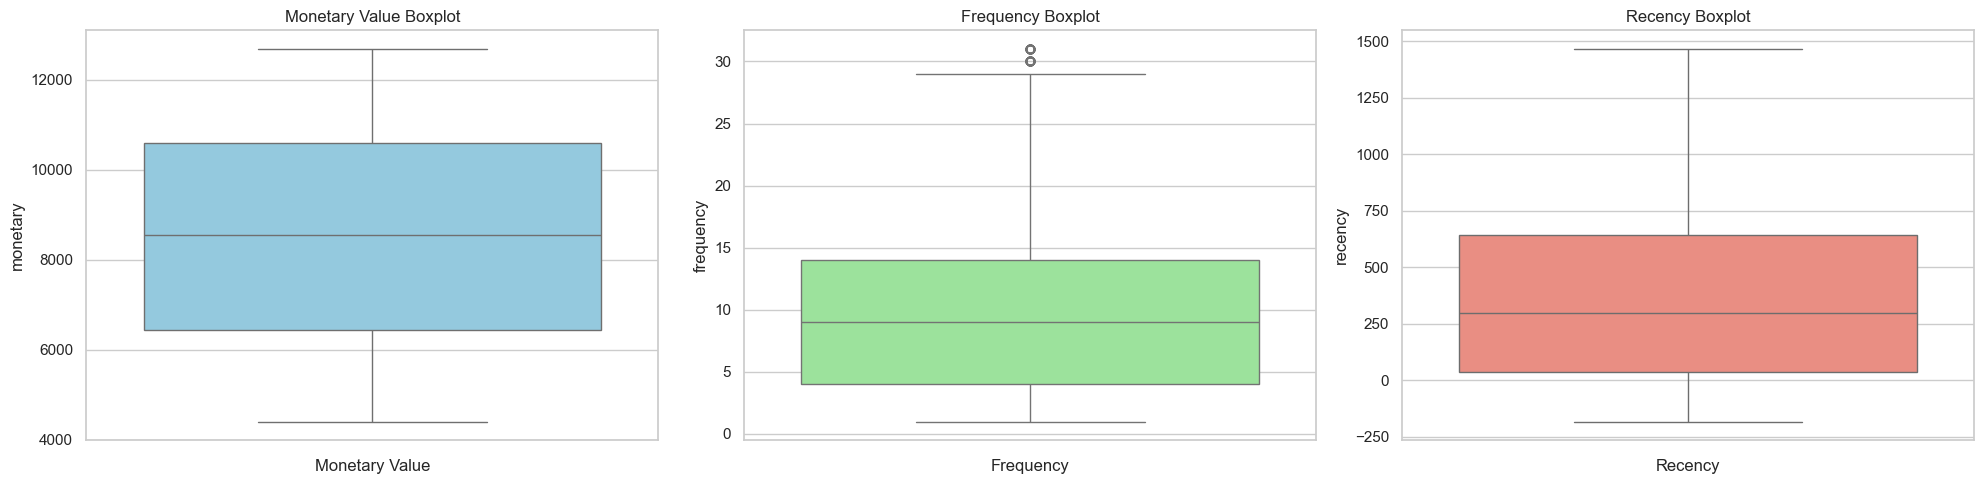

In [657]:
# We using box plot further to see more on the outliers
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=rfm['monetary'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=rfm['frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=rfm['recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

Since the values are in different metrics, we can use standard scalar to have a mean of 0 and std of 1 

Ensuring each feature contributes equally to the analysis

In [658]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(rfm[["monetary", "frequency", "recency"]])

In [659]:
scaled_data_df = pd.DataFrame(scaled_data, index=rfm.index, columns=("monetary", "frequency", "recency"))
scaled_data_df.head()

,monetary,frequency,recency
0,1.318126,-0.430202,-0.023017
1,-1.365754,-1.134596,-0.871935
2,0.530966,-0.852838,0.053462
3,0.447644,0.415071,-0.451300
4,0.675000,0.133314,-0.033215


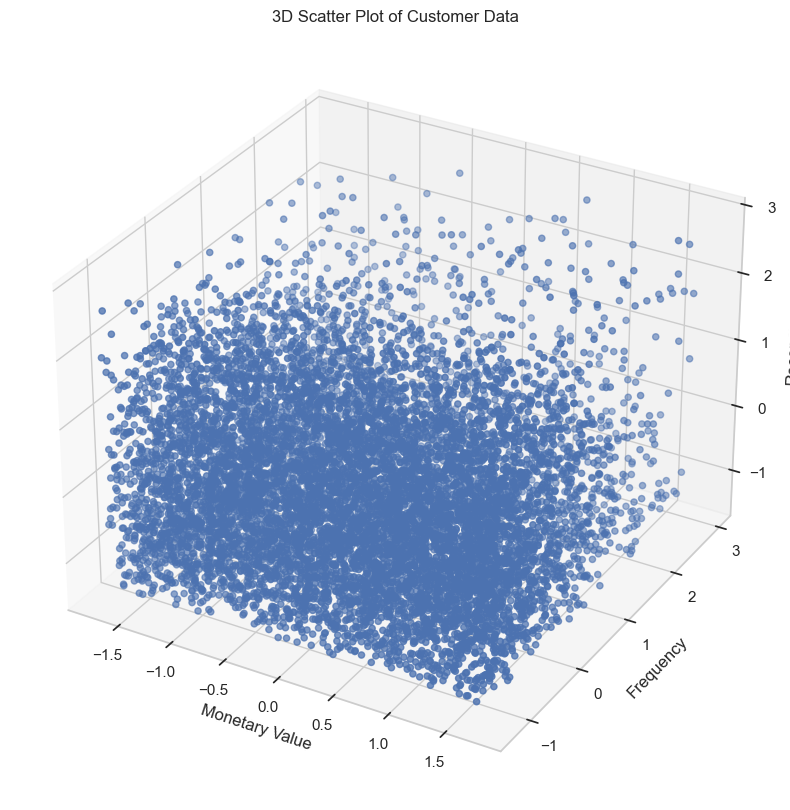

In [660]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["monetary"], scaled_data_df["frequency"], scaled_data_df["recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

K-Means Clustering

In [661]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

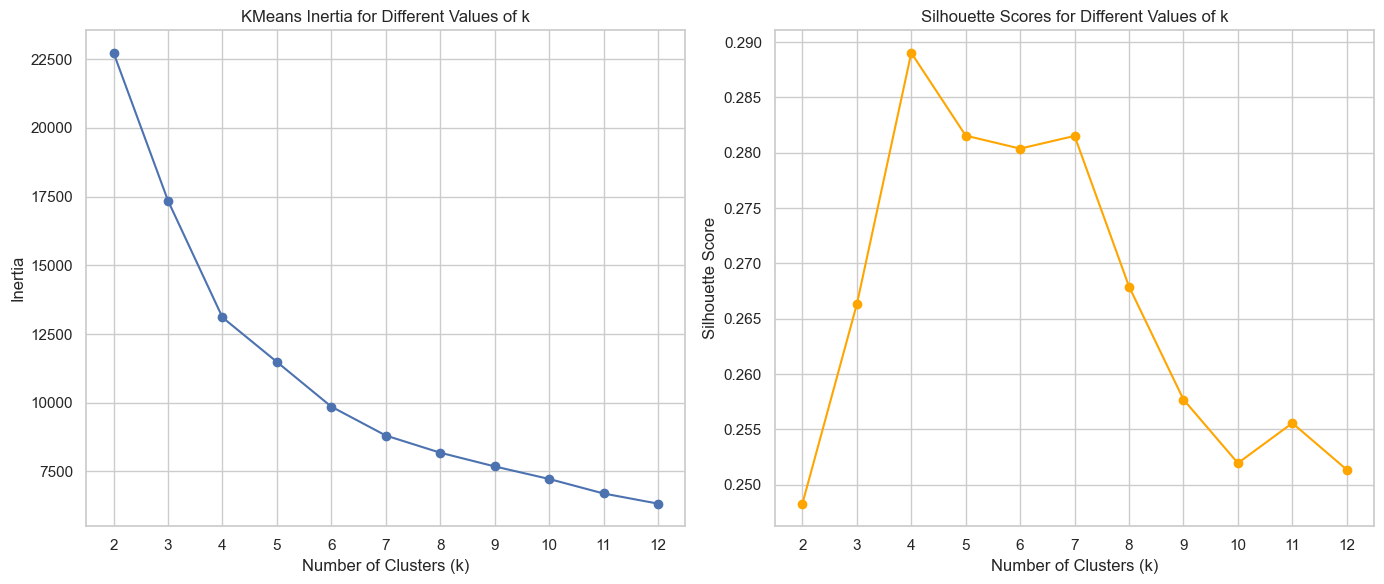

In [662]:
# Let us find ideal k using elbow method 

max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    sil_score = silhouette_score(scaled_data_df, cluster_labels)
    silhoutte_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

- Inertia is reduced the most at K = 4 and 5 after which there is less reduction in inertia. 

- Thus, between 4 and 5, we can take k= 4 which has a higher silhoutee than k = 5. (The silhoutte score ranges between [-1,1] and a higher value indicates more distinct clusters)

In [663]:
# Calculating the clusters
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([1, 2, 1, ..., 3, 2, 1])

In [664]:
# Adding the Clusters to the dataframe
rfm["Cluster"] = cluster_labels

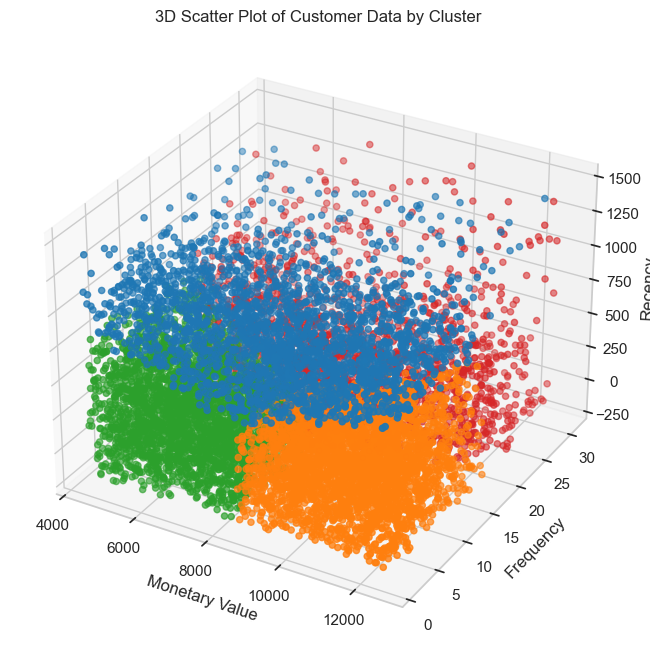

In [665]:
# We can then plot a 3-D plot with different colors for the clusters
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = rfm['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(rfm['monetary'], 
                     rfm['frequency'], 
                     rfm['recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

- It's great to see the various values of the cluster on the data, but we want to be more specific of our analysis, more rigourous analysis
- For that we can use a violin plot to take a look at the distributions across the features

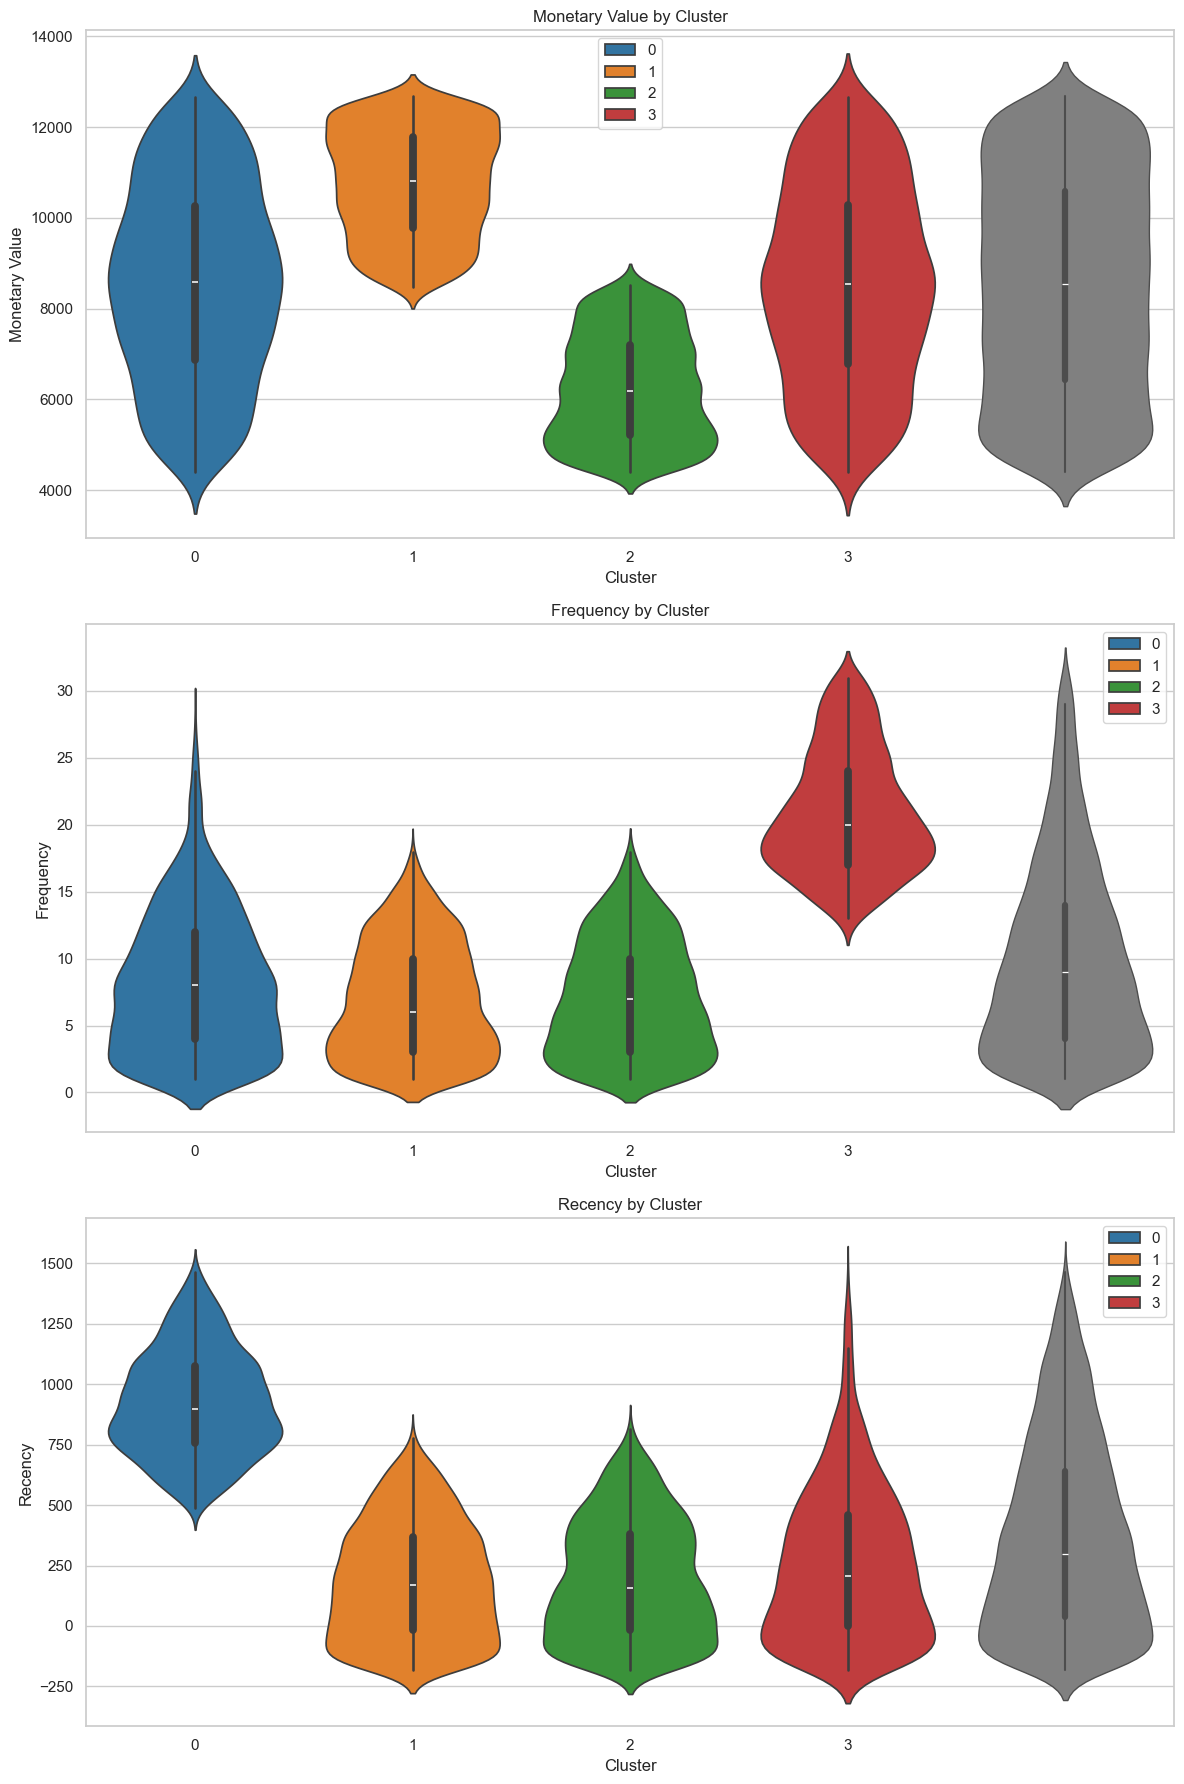

In [666]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=rfm['Cluster'], y=rfm['monetary'], palette=cluster_colors, hue=rfm["Cluster"])
sns.violinplot(y=rfm['monetary'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=rfm['Cluster'], y=rfm['frequency'], palette=cluster_colors, hue=rfm["Cluster"])
sns.violinplot(y=rfm['frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=rfm['Cluster'], y=rfm['recency'], palette=cluster_colors, hue=rfm["Cluster"])
sns.violinplot(y=rfm['recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [673]:
# RFM Summary Statistics by Cluster
rfm_cluster_summary = rfm.groupby('Cluster')[['recency', 'frequency', 'monetary']].agg(['min', 'max', 'mean', 'count'])
rfm_cluster_summary.reset_index()

Cluster recency                         frequency                       \
              min   max        mean count       min max       mean count   
0       0     490  1466  920.319195  2287         1  28   8.146480  2287   
1       1    -182   779  185.405245  2860         1  18   6.911189  2860   
2       2    -182   815  190.753516  2844         1  18   7.072082  2844   
3       3    -182  1434  255.229965  2009        13  31  20.919363  2009   

  monetary                             
       min    max          mean count  
0     4401  12664   8550.608658  2287  
1     8485  12678  10752.623776  2860  
2     4401   8509   6253.225387  2844  
3     4402  12666   8525.058238  2009

## **Interpret the clusters**

**Cluster 0: "Mid-Tier Spenders but Inactive"**

- Recency: Very high mean (920), meaning they haven't made a purchase in a long time.
- Frequency: Moderate (mean ~8 purchases).
- Monetary: High value (mean ~8,550), similar to Cluster 3.
- Strategy: These were good customers who have likely churned. They need "Win-back" campaigns.

**Cluster 1: "Active High-Value Spenders"**
- Recency: Very low/recent (mean 185), indicating recent activity.
- Frequency: Moderate (mean ~7 purchases).
- Monetary: The highest average spenders (mean ~10,752).
- Strategy: These are most profitable "Premium" customers. Focus on loyalty rewards and exclusive offers.

**Cluster 2: "Active Low-Value Spenders"**
- Recency: Very low/recent (mean 190), indicating they are currently active.
- Frequency: Moderate (mean ~7 purchases).
- Monetary: The lowest average spend (mean ~6,253).
- Strategy: These are "Everyday Shoppers." They are active but spend less per transaction. Try upselling or cross-selling to increase their basket size.

**Cluster 3: "Loyal Power Users"**
- Recency: Low/Recent (mean 255).
- Frequency: Exceptionally high (mean ~21 purchases), far outperforming other groups.
- Monetary: High value (mean ~8,525).
- Strategy: These are  most frequent "VIP." They interact with the brand constantly. Use them for referral programs or beta testing new products.

Assign Cluster back to the orginal dataset

In [668]:
# Select only customer_id and rfm_score from RFM dataset
rfm = rfm.reset_index()
rfm_subset = rfm[['customerid', 'Cluster']]

# Merging
clv = pd.merge(clv, rfm_subset, on='customerid', how='inner')
clv.head()

,customerid,firstpurchasedate,lastpurchasedate,totalpurchases,totalrevenue,referralsource,churnindicator,discountsused,productcategory,responsetolastcampaign,feedbackscore,preferredpaymentmethod,supportticketsraised,hasloyaltycard,frequency,AOV,recency,tenure,avgtimebetweenpurchases,Cluster
0,8519,2021-12-31,2022-03-06,7,11670,Online advertisements,0,2,Q02,ignored,4.729998,debit card,0,no,7,1667.142857,360,425,9.285714,1
1,38152,2019-09-27,2023-02-02,20,5260,Traditional media outreach,1,6,F76,purchased,4.184512,cash,0,no,2,263.000000,27,1251,61.200000,2
2,19680,2021-06-13,2022-02-04,29,9790,Influencer endorsements,0,2,X04,opened mail,4.346640,google pay,0,no,4,337.586207,390,626,8.137931,1
3,35744,2021-07-28,2022-08-21,15,9591,Influencer endorsements,0,5,A25,ignored,5.000000,debit card,0,no,13,639.400000,192,581,25.933333,1
4,11663,2021-01-19,2022-03-10,13,10134,Word of mouth,0,3,A16,ignored,4.482089,credit card,0,no,11,779.538462,356,771,31.923077,1


## Evaluate clusters and 6 months CLV to find ideal budget for each segment

In [669]:
# Define windows
snapshot_date = pd.to_datetime('2023-03-01')
end_date = pd.to_datetime('2023-09-01')

# Filter the main dataset for transactions that happened in that 'future' window
future_transactions = clv[(clv['lastpurchasedate'] >= snapshot_date) & 
                          (clv['lastpurchasedate'] < end_date)]

# Sum the revenue per customer to get the 6-month actual CLV
target_y = future_transactions.groupby('customerid')['totalrevenue'].sum().reset_index()

# Rename column to be clear it is our target
target_y.rename(columns={'totalrevenue': '6m_clv'}, inplace=True)

# Merge this back to your 'past_data' (features) 
df_final = pd.merge(clv, target_y, on='customerid', how='left')

# Fill NaN with 0 (customers who existed in the past but spent $0 in those 6 months)
df_final['6m_clv'] = df_final['6m_clv'].fillna(0)

In [670]:
budget_segment = df_final.groupby('Cluster').agg(avg_clv=('6m_clv','mean')).reset_index()

budget_segment['max_budget'] = budget_segment['avg_clv'] / 3 

budget_segment

,Cluster,avg_clv,max_budget
0,0,0.000000,0.000000
1,1,2953.207692,984.402564
2,2,1737.208861,579.069620
3,3,2182.622698,727.540899


### **Budget Strategy - 3:1 LTV:CAC Ratio**



Strategic Recommendations

**Cluster 3 (Loyal Power Users)**

- Insight: With an average CLV of $2,182, these are your highest-value customers.
- Recommendation: Invest up to $727.54 per customer over 6 months. Focus this budget on "Retention" rather than "Acquisition."

**Cluster 1 (Active High-Value Spenders) – High Potential**

- Insight: These customers spend heavily but shop less frequently than cluster 3.
- Recommendation: With an allowable spend of $984, the goal is to increase their "Frequency" to match Cluster 3.

**Cluster 2 (Active Low-Value Spenders) – Efficiency is Key**

- Insight: They are active but spend the least among 3 active groups ($1,737).
- Recommendation: Keep retention costs strictly under $579.

**Cluster 0 (Mid-Tier Spenders but Inactive)**

- Insight: Currently bringing in $0.
- Recommendation: The 3:1 ratio doesn't apply here because LTV is 0. Instead, set a "Fixed Test Budget" (e.g., $50 total) for a re-engagement campaign.

> "Note: This recommendation assumes a 100% gross margin. If the company's product margin is 50%, the allowable spend should be halved ($492 for Cluster 1) to maintain the 3:1 Profit-to-CAC ratio."

To ensure the segments provided actionable business value, I performed a One-Way ANOVA test comparing the segments against the Actual 6-Month CLV.

The results yielded a significant F-Statistic of 315.66 (p < 0.001). This confirms that the behavioral differences identified by the K-Means algorithm (Recency, Frequency, Monetary) are strong predictors of future financial contribution.

In [671]:
from scipy import stats

# 1. Descriptive Validation: Do the means vary significantly?
validation_stats = df_final.groupby('Cluster')['6m_clv'].agg(['mean', 'std']).reset_index()
print(validation_stats)

# 2. Statistical Validation: One-Way ANOVA
# We extract the CLV for each cluster group
group1 = df_final[df_final['Cluster'] == 1]['6m_clv']
group2 = df_final[df_final['Cluster'] == 2]['6m_clv']
group3 = df_final[df_final['Cluster'] == 3]['6m_clv']

f_stat, p_val = stats.f_oneway(group0, group1, group2, group3)

print(f"ANOVA Result: F-Statistic = {f_stat:.2f}, p-value = {p_val:.4f}")

if p_val < 0.05:
    print("MATCH SUCCESSFUL: Segments show statistically significant differences in 6-month value.")
else:
    print("MATCH FAILED: Segments do not significantly differentiate future value.")

   Cluster         mean          std
0        0     0.000000     0.000000
1        1  2953.207692  4831.291946
2        2  1737.208861  2905.859507
3        3  2182.622698  3916.011814
ANOVA Result: F-Statistic = 315.66, p-value = 0.0000
MATCH SUCCESSFUL: Segments show statistically significant differences in 6-month value.


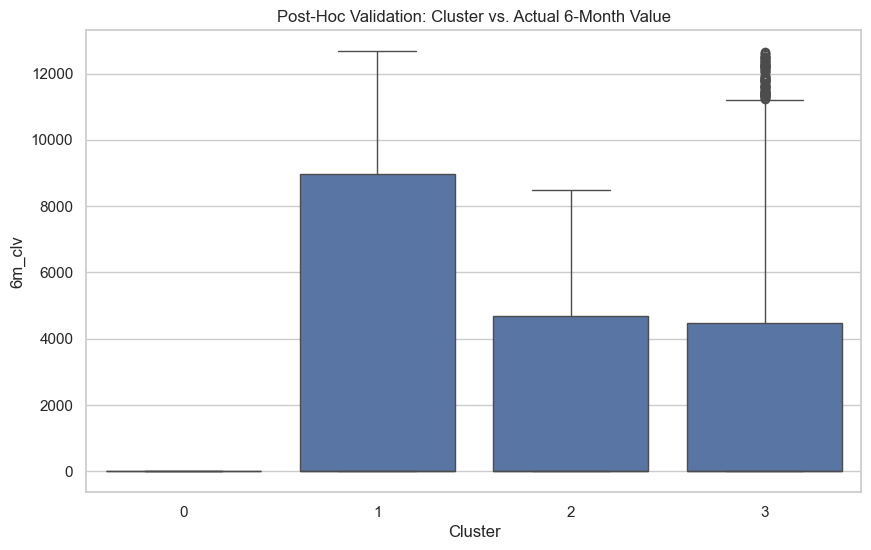

In [672]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Cluster', y='6m_clv', data=df_final)
plt.title('Post-Hoc Validation: Cluster vs. Actual 6-Month Value')
plt.show()

# Conclusion

See the README.md file for a detailed conclusion.